# Imports

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as dataframe
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
# import shap

# !pip install xgboost
# clear_output()
# check xgboost version
import xgboost
print(xgboost.__version__)
from xgboost import XGBClassifier

import pickle
import time

2.0.3


In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.config.list_physical_devices('GPU'))
# print(tf.__version__)
# print(tf.config.list_physical_devices())
print()
print()
# # Check whether GPU is being or not
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
tf_device="GPU:0"
!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Sun May  5 22:02:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  | 00000000:09:00.0  On |                  N/A |
| 53%   40C    P8              58W / 390W |   1502MiB / 24576MiB |      2%      Default |
|                                         |                      |                  N/A |

In [3]:
print(os.getcwd())

base_dir = os.getcwd()
paths={
    'data': join(base_dir, 'data'),
    'amex': join(base_dir, 'data', 'amex'),
    'processed': join(base_dir, 'processed'),
    'datasets': join(base_dir, 'datasets1'),
    'binaries': join(base_dir,'datasets1', 'binaries'),
    'continuous': join(base_dir,'datasets1', 'continuous'),
    'limpos': join(base_dir,'datasets1', 'limpos'),
    'models': join(base_dir,'models'),
    'sampling': join(base_dir,'data', 'sampling'),
    'results': join(base_dir,'results'),
    'features': join(base_dir,'features'),
    
}

D:\github


In [4]:
os.listdir(paths['datasets'])

['.git',
 '8K',
 'amexplorer',
 'binaries',
 'continuous',
 'limpos',
 'malmem2022',
 'motodroid',
 'motodroid-v2',
 'originais',
 'originals',
 'preprocessed',
 'README.md',
 'src',
 'VT_metadata.rar']

In [5]:
files = dataframe(os.listdir(paths['binaries']), columns=['filename'])
files

,filename
0,adroit.csv
1,androcrawl.csv
2,android_permissions.csv
3,defensedroid_prs.csv
4,drebin215.csv
5,kronodroid_emulador.csv
6,kronodroid_real_device.csv


# AMEX-1M dataset

* Permission:  features
* Intent:  features
* Opcodes: features
* Labels: (CLASS, vt_detection)


## Load amex-1m data

In [16]:
def load_amex_1m(path, base_name='amex-1M'):
    data = np.load(join(path, f'{base_name}.npy'))
    metadata = pd.read_csv(
        join(path, f'{base_name}-metadata.csv'), 
        sep=',', 
        # nrows=1,
        on_bad_lines='skip',
        index_col=0 
    ) 
    df_features = pd.read_csv(
        join(path, f'{base_name}-feature_names.csv'), 
        sep=',',
        on_bad_lines='skip',
        # index_col=0 
    )  
    columns_names = df_features['features'].values

    return dataframe(data, columns=columns_names), metadata, columns_names

def create_class(df, threshold):
    return np.asarray([1 if i>=threshold else 0 for i in df ])

def class_distribution(y_data, classes):
        unique_tr, counts_tr = np.unique(y_data, return_counts=True)
        dict(zip(unique_tr, counts_tr))

        pie = plt.pie(counts_tr, autopct=lambda p : '{:.1f}% ({:,.0f})'.format(p, p * sum(counts_tr)/100), radius=1)
        plt.legend(pie[0], shadow=True, loc="lower right", 
                                  bbox_transform=plt.gcf().transFigure)
        plt.show()

def plot_grid(vt_labels, path_save= [], name='plot grid', figsize=(18, 20)):
    fig = plt.figure(figsize=figsize)
    for i, vt in zip (range(0, vt_labels.shape[0]), vt_labels.columns):
        # print(i, idx)
        ax = plt.subplot(7, 6, i + 1)
        # plt.plot(X[idx_sample])
        unique_tr, counts_tr = np.unique(vt_labels[vt], return_counts=True)

        plt.pie(counts_tr, autopct=lambda p : '{:.1f}% ({:,.0f})'.format(p, p * sum(counts_tr)/100), radius=1.5)

        plt.title(vt)
        # plt.ylim(ylim)
        plt.axis("off")
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()
    if path_save:
        fig.savefig(os.path.join(path_save, name+'.png'), format='png', bbox_inches='tight')
    return 

In [10]:
data, metadata, columns_names = load_amex_1m(
    path=paths['amex']
)

In [12]:
# create labels

labels = create_class(df=metadata['VT_SCANNERS'], threshold=4)
metadata['LABELS'] = labels
dataframe(labels).value_counts()

0    813385
1     78972
Name: count, dtype: int64

In [13]:
metadata

,VT_LAST_ANALYSIS_DATE,VT_SIZE,SHA256,VT_MD5,VT_TIMES_SUBMITTED,VT_SCANNERS_FAILURE,VT_SCANNERS_MALICIOUS,VT_SCANNERS_UNDETECTED,VT_SCANNERS_SUGGESTED_THREAT_LABEL,VT_SCANNERS_NAMES,VT_SCANNERS,LABELS
0,2021-10-18 05:26:42,11153644.0,F7E69BAD50EB274081A169111973308294333F92A212F4...,f6022cef562bfaa403ac304b11d1c165,1,1,0,60,NaN,[],0,0
1,2019-08-11 11:30:56,12920431.0,FF8FBF057F9E491C56336EA899F3963C84FD2F0C28A4D3...,ed4e1480af63f0205c1a73a31ebe2504,2,0,0,55,NaN,[],0,0
2,2022-01-30 08:11:17,159297.0,F99E66597467AD0744CBA190786FC2F4A1DE1F55B18D05...,21096e1cf41e6fe95e99d63fe3df921c,13,1,1,57,NaN,['Ikarus'],2,0
3,2020-06-03 12:50:42,8208151.0,FF460EB2830265BFD48E5CBC9EE2AEEFF6B46C15D62194...,2381358a0627d2f091c412eb2dd9159d,2,1,0,61,NaN,[],0,0
4,2019-02-22 22:53:46,2238737.0,F6C5A30B00444056E2835D81411C05A84579386C150630...,7b1dec0cf91e0579783051ee6488b24a,1,0,0,60,NaN,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
892352,2023-01-17 05:10:28,73859390.0,F97ED8E5BC8A774B357071880204EB1219E39554DDB0A0...,6cd2bb997d4c255991da4e1a267c1746,1,1,0,64,NaN,[],0,0
892353,2023-07-30 01:11:03,46851224.0,F8521F6BB752B0F3FE4793CDC80202EBD2D86BB31FA9D8...,ef10042af05e84fbfef83dae8fd484fc,5,0,1,63,NaN,['MaxSecure'],1,0
892354,2023-04-04 02:21:46,44487240.0,FB2404CB8E03ADB706D51D73E8C9E5CB66261E6E0C7A06...,bcfe5f90543169fdea25810acd0ce906,2,0,0,64,NaN,[],0,0
892355,2020-07-14 13:34:30,4137446.0,FDD12ADC4B5C9E60D073526BDA9D3AA9B03F0E2B0DB9A2...,a5440a0a446cd2948537c8791f1da619,1,2,0,62,NaN,[],0,0


## Create AMEX-1M dataset

In [17]:
def create_datasets(data, metadata):

    X_train, X_test, y_train, y_test = train_test_split( 
        data, metadata, 
        test_size=0.30, 
        random_state=0, 
        shuffle=True
    )
    
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    encoder_binary = OneHotEncoder().fit(np.expand_dims(metadata['LABELS'].values, axis=1))
    
    data_dict = {
        'X_train': X_train,
        'y_train_metadata': y_train,
        'y_train_ohe': encoder_binary.transform(np.expand_dims(y_train['LABELS'].values, axis=1)),
        'X_test': X_test,
        'y_test_metadata': y_test,
        'y_test_ohe': encoder_binary.transform(np.expand_dims(y_test['LABELS'].values, axis=1)),
        'classes_names': ['Benign', 'Malware']
        # 'classes': ['Normal', 'Supraventricular', 'Ventricular'],
    }
    
    return data_dict

In [18]:
data_dict = create_datasets(data, metadata)

(624649, 861) (267708, 861) (624649, 12) (267708, 12)


In [21]:
with open(join(paths['amex'], 'amex-1M.pickle'), 'wb') as f:
    pickle.dump(data_dict, f)

# Load dataset AMEX-1M

In [6]:
with open(join(paths['amex'], 'amex-1M.pickle'), 'rb') as f:
    data_dict= pickle.load(f)

print(data_dict.keys())

dict_keys(['X_train', 'y_train_metadata', 'y_train_ohe', 'X_test', 'y_test_metadata', 'y_test_ohe', 'classes_names'])


In [8]:
chi2_features = pd.read_csv(join(paths['amex'], 'amex-1M-chi2-features.csv'))
chi2_features

,names,stats,p_values
0,INTENTS_USER_PRESENT,61086.290137,0.000000
1,INTENTS_EXTERNAL_APPLICATIONS_AVAILABLE,53868.843143,0.000000
2,INTENTS_PACKAGE_ADDED,48310.752642,0.000000
3,PERMISSIONS_GET_ACCOUNTS_PRIVILEGED,46844.051851,0.000000
4,INTENTS_RSSI_CHANGED,45753.212668,0.000000
...,...,...,...
673,INTENTS_USER_INITIALIZE,3.964233,0.046477
674,INTENTS_ACTION_USER_BACKGROUND,3.911212,0.047965
675,INTENTS_SCO_AUDIO_STATE_CHANGED,3.890493,0.048560
676,OPCODES_const/16,3.865808,0.049279


In [10]:
chi2_features['names'][0:200].values

array(['INTENTS_USER_PRESENT', 'INTENTS_EXTERNAL_APPLICATIONS_AVAILABLE',
       'INTENTS_PACKAGE_ADDED', 'PERMISSIONS_GET_ACCOUNTS_PRIVILEGED',
       'INTENTS_RSSI_CHANGED', 'PERMISSIONS_READ_PHONE_STATE',
       'INTENTS_PACKAGE_REMOVED', 'INTENTS_ACTION_BUG_REPORT',
       'PERMISSIONS_READ_LOGS',
       'PERMISSIONS_CREDENTIAL_MANAGER_SET_ORIGIN',
       'PERMISSIONS_BIND_MIDI_DEVICE_SERVICE',
       'PERMISSIONS_WRITE_APN_SETTINGS', 'PERMISSIONS_GET_TASKS',
       'PERMISSIONS_SYSTEM_ALERT_WINDOW', 'PERMISSIONS_CHANGE_WIFI_STATE',
       'OPCODES_ushr-long/2addr', 'OPCODES_sub-double',
       'OPCODES_rem-long/2addr', 'OPCODES_or-long', 'OPCODES_iget-char',
       'PERMISSIONS_BIND_INCALL_SERVICE', 'PERMISSIONS_BIND_CONTROLS',
       'PERMISSIONS_SEND_SMS', 'PERMISSIONS_INSTALL_SHORTCUT',
       'PERMISSIONS_ACCESS_LOCATION_EXTRA_COMMANDS',
       'OPCODES_shl-long/2addr', 'OPCODES_shr-int', 'OPCODES_xor-long',
       'OPCODES_iget-short', 'PERMISSIONS_WRITE_CALL_LOG',
       'OP

# Train a model

In [12]:
import models
import trainer
import importlib
importlib.reload(models)
importlib.reload(trainer)

<module 'trainer' from 'D:\\github\\trainer.py'>

In [20]:
import gc
def pipeline_train_models(
    data_dict, models_list, dataset_name='amex-1M', sufix_title='original', path_save=join(base_dir, 'models'), feature_list=None):

    # for dataset_name in datasets.keys():
    #     print(f'Dataset name: {dataset_name}')
    for model_name in models_list:
        print()
        print()
        print(f'=========================================================================')
        print(f'===================== Model name: {model_name} ==========================')
        print(f'=========================================================================')
        
        experiment_name = f'{dataset_name}-{model_name}-{sufix_title}'
        print('\t',experiment_name)
        experiment_path = join(path_save, experiment_name)
        
        if os.path.exists(experiment_path):
            print(f"\tExperiment already exists. ")
            print(f'\t============================================================================================')
            print(f'\t\====================== Skipping {experiment_name} =====================')
            print(f'\t============================================================================================')
            continue
        else:
            os.makedirs(experiment_path)

        X_train, X_test = [], []
        if feature_list is not None:
            X_train = data_dict['X_train'][feature_list]
            X_test = data_dict['X_test'][feature_list]
        else:
            X_train = data_dict['X_train']
            X_test = data_dict['X_test']
        print(f'\tDataset shape: Train {X_train.shape}, Test {X_test.shape}')

        print(f"\tTraining {model_name}")
        model=[]
        extension='.joblib'
        if model_name=='xgboost':
            model, time_duration = trainer.train( 
                X=X_train.values , y=data_dict['y_train_ohe'].toarray(), model_name=model_name)
            extension='.joblib'
        elif model_name=='randomforest':
            model, time_duration = trainer.train( 
                X=X_train.values, y=data_dict['y_train_ohe'].toarray(), model_name=model_name)
            extension='.joblib'
        elif model_name=='svm':
            model, time_duration = trainer.train( 
                X=X_train.values, y=data_dict['y_train_ohe'].toarray(), model_name=model_name)
            extension='.joblib'
        elif model_name=='knn':
            model, time_duration = trainer.train( 
                X=X_train.values, y=data_dict['y_train_ohe'].toarray(), model_name=model_name)
            extension='.joblib'
        elif model_name=='fcn':
            model, time_duration = trainer.build_deep_model(
                X=X_train.values, y=data_dict['y_train_ohe'].toarray(), 
                num_classes=len(data_dict['classes_names']), 
                model_name=experiment_name, 
                path_experiment=experiment_path)
            extension='.h5'

            model = tf.keras.models.load_model(join(experiment_path, f'{experiment_name}_loss.keras'))
        else:
            raise Exception (f'Model Not Found on pipeline_train_models()')
            os.remove(experiment_path)
            return []

        trainer.save_model(
            model=model, 
            directory=experiment_path, 
            filename= experiment_name,
            extension=extension
            )
        
        with open(join(experiment_path, f'{experiment_name}-time.txt'), 'w') as file:
            file.write(f'{time_duration:.4f}')
        print(f"\tEvaluating {model_name}")
        
        pred, cm, report = trainer.eval(
            X=X_test.values, 
            # y_true=np.argmax(y_test, axis=1), 
            y_true=data_dict['y_test_ohe'].toarray(), 
            model=model,
            class_labels=data_dict['classes_names'],
            dataset_name=dataset_name,
            model_name=model_name,
            path_save=experiment_path
        )

        gc.collect()

        print('---------------------------------------------------------------------------------------------------------------')
        print('')
        print('')
        
importlib.reload(models)
importlib.reload(trainer)

<module 'trainer' from 'D:\\github\\trainer.py'>



===================== Model name: xgboost ==========================
	 amex-1M-xgboost-chi2-200
	Dataset shape: Train (624649, 200), Test (267708, 200)
	Training xgboost
Took 6.5463 seconds to train the xgboost
	Evaluating xgboost
(267708,) (267708,)

              precision    recall  f1-score   support

           0     0.9755    0.9928    0.9841    244034
           1     0.9096    0.7430    0.8179     23674

    accuracy                         0.9707    267708
   macro avg     0.9426    0.8679    0.9010    267708
weighted avg     0.9697    0.9707    0.9694    267708

---------------------------------------------------------------------------------------------------------------




===================== Model name: randomforest ==========================
	 amex-1M-randomforest-chi2-200
	Dataset shape: Train (624649, 200), Test (267708, 200)
	Training randomforest
Took 37.0968 seconds to train the randomforest
	Evaluating randomforest
(267708,) (267708,)

              precision  

OSError: No file or directory found at D:\github\models\amex-1M-fcn-chi2-200\fcn_loss.keras

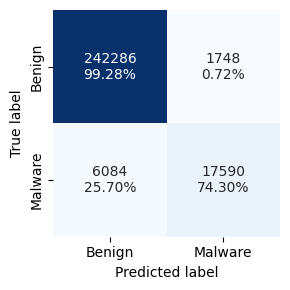

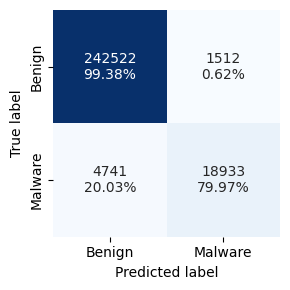

In [21]:
pipeline_train_models(
    data_dict=data_dict, 
    models_list=['xgboost', 'randomforest', 'fcn'], #'knn', 'svm'
    dataset_name='amex-1M', 
    sufix_title='chi2-200', 
    path_save=join(base_dir, 'models'),
    feature_list = chi2_features['names'][0:200].values
)

## Example usage

In [ ]:
def train(X_train, y_train, X_test, y_test, class_names, classifier='xgboost'):
    model, y_pred, acc, cm, report= [], [], [], [], []
    if classifier=='xgboost':
        model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names)
    print("Accuracy:", acc)

    return model, y_pred, cm, report

def plot_cm(cm, figsize=(4, 3)):
    fig= plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, cmap='Blues', linewidth=.5, fmt=".1f")
    return

def plot_importance(model, threshold=0.01, feature_names=[], figsize=(4, 3)):
    fig= plt.figure(figsize=figsize)
    indices = np.argsort(model.feature_importances_)
    importance = dataframe({'features':feature_names[indices], 'values': model.feature_importances_[indices]})
    importance = importance[::-1].reset_index(drop=True)
    sns.barplot(data=importance[importance['values']>threshold],
           y='features', x='values',
           orient= 'h')

    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing importance scores")
    plt.yticks(fontsize=6)
    # plt.legend(xg_model.classes_)
    plt.show()
    return importance

def shap_explainer(model, X, y):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    return explainer, shap_values

In [33]:
## Train test split

id_train, id_val = train_test_split(range(0, data.shape[0]), test_size=0.2, random_state=0, shuffle=True)
print(len(id_train), len(id_val))

X_train = np.expand_dims(data[id_train], 2)
X_val = np.expand_dims(data[id_val], 2)
y_train = vt_labels.iloc[id_train]['4-class']
y_val = vt_labels.iloc[id_val]['4-class']

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

81547 20387
(81547, 24833, 1) (20387, 24833, 1)
(81547,) (20387,)


In [34]:
# ## Split dataset
#X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=0, shuffle=True)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
enc__ = OneHotEncoder(dtype=int)
enc__.fit(np.expand_dims(y_train.values, axis=1))
y_train_ohe = enc__.transform(np.expand_dims(y_train.values, axis=1))
y_val_ohe = enc__.transform(np.expand_dims(y_val.values, axis=1))

print(dataframe(y_train).value_counts(), dataframe(y_val).value_counts())

(81547, 24833, 1) (20387, 24833, 1) (81547,) (20387,)
4-class
0          73752
1           7795
dtype: int64 4-class
0          18382
1           2005
dtype: int64


In [ ]:
# y_train['1-class'], vt_labels.iloc[:, 0]

In [ ]:
# print(data.shape)

# vt_count = 4

# labels = vt_labels[str(vt_count)+'-class']
# labels.head()

### Clasical Model

In [ ]:
# XGBOOST
model, y_pred, cm, report = train(X_train, y_train, X_val, y_val, class_names=['authentic', 'malware'], classifier='xgboost')
# model, y_pred, cm, report = train(fs_data, y_train, fs_test, y_val, class_names=['benign', 'malware'], classifier='xgboost')


In [ ]:
print(cm)

In [ ]:
plot_cm(cm)

In [ ]:
print(report)

In [ ]:
c_names = dataframe(column_names['features']).iloc[selected_indices]['features'].values
c_names

In [ ]:
importance = plot_importance(model, threshold=0.01, feature_names=c_names, figsize=(6, 4))


### CNN Model

In [ ]:
# X_train = np.expand_dims(np.load(join(paths['processed'], 'X_train.npy')), axis=2)
# X_val = np.expand_dims(np.load(join(paths['processed'], 'X_val.npy')), axis=2)
# y_train = np.load(join(paths['processed'], 'y_train.npy'))
# y_val = np.load(join(paths['processed'], 'y_val.npy'))


# enc__ = OneHotEncoder()
# enc__.fit(np.expand_dims(y_train, axis=1))
# y_train_ohe = enc__.transform(np.expand_dims(y_train, axis=1))
# y_val_ohe = enc__.transform(np.expand_dims(y_val, axis=1))

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
# from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import load_model, save_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# tf_device="GPU:0"
# !nvidia-smi

C:\Users\hendr\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18187661016988809313
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22722641920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3067248886316702858
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:09:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [41]:
# Baseline network
def simple_cnn(input_shape,  num_classes):
    input_= layers.Input(input_shape)

    conv = layers.Conv1D(filters=512, kernel_size=9, strides=1, padding='same', name='conv_1')(input_)
    conv = layers.MaxPooling1D(pool_size=4)(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same', name='conv_2')(conv)
    conv = layers.MaxPooling1D(pool_size=2)(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', name='conv_3')(conv)
    conv = layers.MaxPooling1D(pool_size=2)(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)


    conv = layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name='conv_4')(conv)
    conv = layers.MaxPooling1D(pool_size=2)(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)

    gap_layer = layers.GlobalAveragePooling1D(name='GAP')(conv)

    # dense_layer = layers.Dense(16, activation='relu', name='dense_layer')(gap_layer)
    out = layers.Dense(num_classes, activation='softmax', name='predictions')(gap_layer)

    return tf.keras.models.Model(inputs=input_, outputs=out)


def callbacks(path):
      
    loss = tf.keras.callbacks.ModelCheckpoint(path+'_loss.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
    acc = tf.keras.callbacks.ModelCheckpoint(path+'_acc.h5',save_best_only=True, monitor='val_accuracy', mode='max', verbose=2)
    f1 = tf.keras.callbacks.ModelCheckpoint(path+'_f1.h5', save_best_only=True, monitor='val_f1_score', mode='max', verbose=2)
    history = keras.callbacks.CSVLogger(path+'_history.csv')
    
    return [acc, loss, f1, history]

### Train model

In [36]:
print(X_train.shape)

input_shape = (X_train.shape[1], 1)
print(input_shape)
# class_names = np.unique(dataset['DS1']['labels'])
# class_names = np.unique(y_train)
print(classes_names)
f1__ = tfa.metrics.F1Score(num_classes= len(classes_names), average='macro')

(81547, 24833, 1)
(24833, 1)
['authentic', 'malware']


In [37]:
print(os.getcwd())

model_name = 'MH-100K'
print(model_name)

path = join(paths['models'], model_name)
print(path)

D:\github
MH-100K
D:\github\models\MH-100K


In [44]:
# tf.config.run_functions_eagerly(False)
with tf.device('/gpu:0'):
    model = simple_cnn(input_shape=input_shape,  num_classes=2)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy", f1__],
    )
    model.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24833, 1)]        0         
                                                                 
 conv_1 (Conv1D)             (None, 24833, 512)        5120      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 6208, 512)        0         
 g1D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 6208, 512)        2048      
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 6208, 512)         0         
                                                                 
 conv_2 (Conv1D)             (None, 6208, 256)         3934

In [45]:
# tf.config.run_functions_eagerly(True)

with tf.device('/gpu:0'):

    history = model.fit(
        X_train,
        # np.expand_dims(X_train, axis=2),
        y_train_ohe.toarray(),
        validation_split=0.2,
        epochs=50,
        batch_size=128,
        callbacks= callbacks(path)
    )

Epoch 1/50
510/510 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.8985 - f1_score: 0.5120
Epoch 1: val_accuracy improved from -inf to 0.88210, saving model to D:\github\models\MH-100K_acc.h5

Epoch 1: val_loss improved from inf to 0.56785, saving model to D:\github\models\MH-100K_loss.h5

Epoch 1: val_f1_score improved from -inf to 0.48999, saving model to D:\github\models\MH-100K_f1.h5
510/510 [==============================] - 242s 462ms/step - loss: 0.2845 - accuracy: 0.8985 - f1_score: 0.5120 - val_loss: 0.5678 - val_accuracy: 0.8821 - val_f1_score: 0.4900
Epoch 2/50
510/510 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9169 - f1_score: 0.6104
Epoch 2: val_accuracy improved from 0.88210 to 0.93213, saving model to D:\github\models\MH-100K_acc.h5

Epoch 2: val_loss improved from 0.56785 to 0.16893, saving model to D:\github\models\MH-100K_loss.h5

Epoch 2: val_f1_score improved from 0.48999 to 0.72235, saving model to D:\github\mode

### Results

In [47]:
paths['models']

'D:\\github\\models'

In [54]:
name__ = 'MH-100K'

best_model = tf.keras.models.load_model(join(paths['models'], name__+'_loss.h5'))

In [55]:
# acc = metrics.accuracy_score(y_test, y_pred)
scores = best_model.evaluate(np.expand_dims(X_val, axis=2), y_val_ohe.toarray())

638/638 [==============================] - 16s 25ms/step - loss: 0.0807 - accuracy: 0.9732 - f1_score: 0.9285


In [50]:
y_pred = model.predict(np.expand_dims(X_val, axis=2))
y_pred_class = np.argmax(y_pred, axis=1)

638/638 [==============================] - 16s 24ms/step


In [51]:
cm = confusion_matrix(y_val, y_pred_class)
print(cm)

[[15416  2966]
 [   46  1959]]


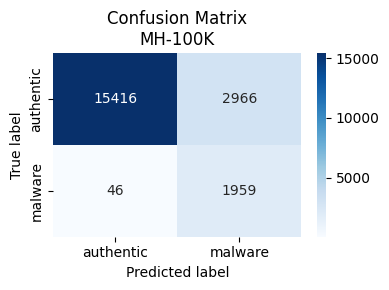

In [52]:
figure = plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix\n'+model_name)
plt.xticks(ticks=[.5, 1.5], labels = classes_names)
plt.yticks(ticks=[.5, 1.5], labels = classes_names)
plt.tight_layout()
plt.savefig(join(paths['models'], name__+'_cm.png'), format='png')

In [53]:
report = classification_report(y_true=y_val, y_pred=y_pred_class, target_names=classes_names)
print(report)

              precision    recall  f1-score   support

   authentic       1.00      0.84      0.91     18382
     malware       0.40      0.98      0.57      2005

    accuracy                           0.85     20387
   macro avg       0.70      0.91      0.74     20387
weighted avg       0.94      0.85      0.88     20387



In [ ]:
with open(join(paths['models'], name__+'_report.json'), 'w') as outfile:
    outfile.write(report)

In [73]:
def plot_results(history, type='loss', title='Model', path_save=[], figsize=(10, 1), show=True):
    if type=='loss':
        values = {'loss':history.history.get('loss'), 'val_loss':history.history.get('val_loss')}
    elif type=='acc' or type=='accuracy':
        values = {'accuracy':history.history.get('accuracy'), 'val_accuracy':history.history.get('val_accuracy')}
    # elif type=='recall':
    #     values = {'recall':history.history.get('recall'), 'val_recall':history.history.get('val_recall')}
    # elif type=='precision':
        values = {'precision':history.history.get('precision'), 'val_precision':history.history.get('val_precision')}
    elif type=='f1' or type=='f1_score':
        values = {'f1_score':history.history.get('f1_score'), 'val_f1_score':history.history.get('val_f1_score')}
    else:
        print('Invalid type')
        return []

    fig = plt.figure(figsize=figsize)
    plt.plot(pd.DataFrame(values))
    plt.title('['+type+'] '+title)
    plt.ylabel(type)
    plt.ylim([0, 1.1])
    plt.xlabel('Epoch')
    plt.legend([type, 'val_'+type], loc='upper left')

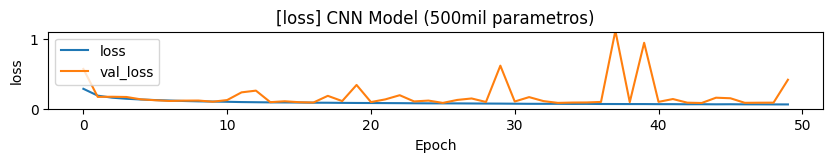

In [74]:
plot_results(history, type='loss', title='CNN Model (500mil parametros)')

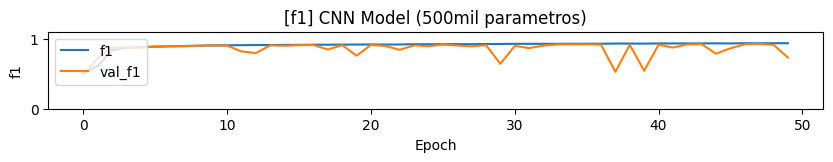

In [76]:
plot_results(history, type='f1', title='CNN Model (500mil parametros)')

## Evaluate

# Explain

In [21]:
import gc
import tqdm
import explainer
from explainer import Explanation

def explain(models, path_save=join(base_dir, 'results', 'explain')):

    # for dataset_name in datasets.keys():
    #     print(f'Dataset name: {dataset_name}')
    for model_name in models.keys():
        
        print(f'===================== Model name: {model_name} ==========================')
        for classification in models[model_name].keys():
            print(f'Classification type: {classification}')
            for dataset in models[model_name][classification].keys():
                model = models[model_name][classification][dataset]['model']
                model_type = models[model_name][classification][dataset]['type']
                model_path = models[model_name][classification][dataset]['model_path']
                explainers = models[model_name][classification][dataset]['explainers']
                dataset_name= models[model_name][classification][dataset]['dataset_name']
                dataset_path = models[model_name][classification][dataset]['path_data']
                test_path = models[model_name][classification][dataset]['path_test']
                background_path = models[model_name][classification][dataset]['background']
                balanced_path = models[model_name][classification][dataset]['balanced']

                print(f"\tLoading Dataset...")

                with open(dataset_path, 'rb') as f:
                    data_dict = pickle.load(f)

                encoder = OneHotEncoder()
                encoder.fit(np.expand_dims(data_dict['y_train_metadata']['LABELS'], axis=1))
                
                with open(background_path, 'rb') as f:
                     background = pickle.load(f)
                with open(balanced_path, 'rb') as f:
                     balanced = pickle.load(f)
                print('\t\t', background['X'].shape, balanced['X'].shape)
                
                input_labels = encoder.transform(np.expand_dims(balanced['labels'], axis=1)).toarray()

                print('\t\t', background['X'].shape, balanced['X'].shape)

                for exp in explainers:
                    print(f"\tExplainer: {exp}")
                    
                    experiment_name = f'{model_name}-{dataset_name}-{classification}-{exp}'
                    print(f"\t\t\tExperiment name: {experiment_name}")
                    experiment_path = join(path_save, experiment_name)
    
                    if os.path.exists(experiment_path):
                        print(f"\t\tExperiment already exists. ")
                        print(f'\t\t================ Skipping {experiment_name} ================')
                        continue
                    else:
                        os.makedirs(experiment_path)
                    
                    # ['SaliencyMap', 'DeepExplainer', 'LimeTabularExplainer', 'Explainer', 'KernelExplainer', 'GradientExplainer']
                    # if exp !='Explainer' and model_name!='fcn' and dataset_name!='sax':
                    #     print('Skipping.........')
                    #     continue

                    scores = []
                    start_time = time.time()
                    explainer__,  scores = Explanation.make_explanation(
                        explainer=exp, 
                        model=model, 
                        input_data =balanced['X'].values, 
                        background=background['X'].values,
                        input_labels=input_labels
                    )

                    end_time = time.time()
                    execution_time = end_time - start_time
                    
                    np.save(join(experiment_path, experiment_name), scores)
                    # dump(explainer__, join(experiment_path, f'{experiment_name}-explainer.pkl')) # joblib
                    # Save the execution time to a text file
                    with open(join(experiment_path, f'{experiment_name}-time.txt'), "w") as file:
                        file.write(f"{execution_time}")

                    gc.collect()

In [22]:
import importlib

import experiments
from experiments import Experiments

importlib.reload(experiments)

<module 'experiments' from 'D:\\github\\experiments.py'>

In [23]:
models_dict = Experiments.get_models_dict(paths)
models_dict

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 861)]             0         
                                                                 
 reshape (Reshape)           (None, 861, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 861, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 430, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 430, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 430, 32)           0     

{'xbgoost': {'binary': {'original': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                  colsample_bylevel=None, colsample_bynode=None,
                  colsample_bytree=None, device=None, early_stopping_rounds=None,
                  enable_categorical=False, eval_metric=None, feature_types=None,
                  gamma=None, grow_policy=None, importance_type=None,
                  interaction_constraints=None, learning_rate=None, max_bin=None,
                  max_cat_threshold=None, max_cat_to_onehot=None,
                  max_delta_step=None, max_depth=None, max_leaves=None,
                  min_child_weight=None, missing=nan, monotone_constraints=None,
                  multi_strategy=None, n_estimators=None, n_jobs=None,
                  num_parallel_tree=None, random_state=None, ...),
    'type': 'classic',
    'model_path': 'D:\\github\\models\\amex-1M-xgboost-original\\amex-1M-xgboost-original.joblib',
    'explainers': ['TreeExplainer

In [ ]:
explain(
    models=models_dict, 
    path_save=join(base_dir, 'data', 'explainers'))

===================== Model name: xbgoost ==========================
Classification type: binary
	Loading Dataset...
		 (40000, 861) (300, 861)
		 (40000, 861) (300, 861)
	Explainer: TreeExplainer
			Experiment name: xbgoost-amex-1M-original-binary-TreeExplainer
Generating TreeExplainer Explanations...
	Explainer: LimeTabularExplainer
			Experiment name: xbgoost-amex-1M-original-binary-LimeTabularExplainer
Generating LimeTabularExplainer Explanations...


100%|████████████████████████████████████████████████████████████| 300/300 [1:24:23<00:00, 16.88s/it]


===================== Model name: randomforest ==========================
Classification type: binary
	Loading Dataset...
		 (40000, 861) (300, 861)
		 (40000, 861) (300, 861)
	Explainer: TreeExplainer
			Experiment name: randomforest-amex-1M-original-binary-TreeExplainer
Generating TreeExplainer Explanations...


In [ ]:
import gc
import tqdm
import explainer
from explainer import Explanation

importlib.reload(explainer)    

def explain(models, path_save=join(base_dir, 'results', 'explain')):

    # for dataset_name in datasets.keys():
    #     print(f'Dataset name: {dataset_name}')
    for model_name in models.keys():
        
        print(f'=========================================================================')
        print(f'===================== Model name: {model_name} ==========================')
        print(f'=========================================================================')
        for classification in models[model_name].keys():
            print(f'\tClassification type: {classification}')
            for dataset in models[model_name][classification].keys():
                print(f'\t================================================================')
                print(f'\t===================== Dataset: {dataset} ========================')
                print(f'\t================================================================')
                model = models[model_name][classification][dataset]['model']
                model_type = models[model_name][classification][dataset]['type']
                model_path = models[model_name][classification][dataset]['model_path']
                explainers = models[model_name][classification][dataset]['explainers']
                dataset_name= models[model_name][classification][dataset]['dataset_name']
                dataset_path = models[model_name][classification][dataset]['path_data']
                test_path = models[model_name][classification][dataset]['path_test']
                background_path = models[model_name][classification][dataset]['background']
                balanced_path = models[model_name][classification][dataset]['balanced']

                print(f"\tLoading Dataset...")

                with open(dataset_path, 'rb') as f:
                    data_dict = pickle.load(f)

                encoder = OneHotEncoder()
                encoder.fit(np.expand_dims(data_dict['labels']['labels_binary'], axis=1))

                # X_train, X_val, y_train, y_val = train_test_split( 
                #     data_dict['X'], data_dict['labels'], test_size=0.20, random_state=0, shuffle=True) # ensure random_state=0 for consistency in results
                # print('\t\t', X_train.shape, X_val.shape, y_train.shape,  y_val.shape)
                # print(f"\tLoading Testdata...")
                # with open(test_path, 'rb') as f:
                #     test_dict = pickle.load(f)
                
                with open(background_path, 'rb') as f:
                     background = pickle.load(f)
                with open(balanced_path, 'rb') as f:
                     balanced = pickle.load(f)
                print('\t\t', background['X'].shape, balanced['X'].shape)
                
                input_labels = encoder.transform(np.expand_dims(balanced['labels']['labels_binary'], axis=1)).toarray()

                print('\t\t', background['X'].shape, balanced['X'].shape)

                for exp in explainers:
                    print(f'\t\t====================================================================')
                    print(f'\t\t==================== Explainer: {exp} ======================')
                    print(f'\t\t====================================================================')
                    # print(f"\tExplainer: {exp}")
                    
                    experiment_name = f'{model_name}-{dataset_name}-{classification}-{exp}'
                    print(f"\t\t\tExperiment name: {experiment_name}")
                    experiment_path = join(path_save, experiment_name)
    
                    if os.path.exists(experiment_path):
                        print(f"\t\tExperiment already exists. ")
                        print(f'\t\t============================================================================================')
                        print(f'\t\t====================== Skipping {experiment_name} =====================')
                        print(f'\t\t============================================================================================')
                        continue
                    else:
                        os.makedirs(experiment_path)
                    
                    # ['SaliencyMap', 'DeepExplainer', 'LimeTabularExplainer', 'Explainer', 'KernelExplainer', 'GradientExplainer']
                    # if exp !='Explainer' and model_name!='fcn' and dataset_name!='sax':
                    #     print('Skipping.........')
                    #     continue

                    scores = []
                    start_time = time.time()
                    explainer__,  scores = Explanation.make_explanation(
                        explainer=exp, 
                        model=model, 
                        input_data =balanced['X'].astype(np.float32), 
                        background=background['X'].astype(np.float32),
                        input_labels=input_labels
                    )

                    end_time = time.time()
                    execution_time = end_time - start_time
                    
                    np.save(join(experiment_path, experiment_name), scores)
                    # dump(explainer__, join(experiment_path, f'{experiment_name}-explainer.pkl')) # joblib
                    # Save the execution time to a text file
                    with open(join(experiment_path, f'{experiment_name}-time.txt'), "w") as file:
                        file.write(f"{execution_time}")

                    gc.collect()

        print('---------------------------------------------------------------------------------------------------------------')
        print('')
        print('')


In [ ]:
explain(
    models=models_dict, 
    path_save=join(base_dir, 'data', 'explainers'))

# Older functions

In [ ]:
def filter_dataframe(df_data, df_features, feat_value):
    df__ = df_features.head(feat_value)
    feat_names = df__['names'].values
        
    filter_data = df_data.filter(feat_names)
    
    return filter_data


def run_features(df_data, vt_labels, df_features, feat_list):
    y = tf.keras.utils.to_categorical(vt_labels)
    id_train, id_val = train_test_split(range(0, df_data.shape[0]), test_size=0.2, random_state=0, shuffle=True)
    print('train and test size: ', len(id_train), len(id_val))
    # y_train_ohe = y[id_train] 
    # y_val_ohe = y[id_val] 
    for feat in feat_list:
        filter_data = filter_dataframe(df_data, df_features, feat)
        print(filter_data.shape)
        print(feat)
        model, y_pred, cm, report = train(
            X_train=filter_data.iloc[id_train].values, 
            y_train=vt_labels[id_train], 
            X_test=filter_data.iloc[id_val].values, 
            y_test=vt_labels[id_val], 
            class_names=['authentic', 'malware'], 
            classifier='xgboost')

        print(cm)
        print(report)
        print()
        print()
    return 

In [ ]:
feature_names =  pd.read_csv(join(path_dataset, 'motodroid-v2-features-all.csv'))

df_data = dataframe(data, columns=feature_names['features'].values)


In [ ]:
files = dataframe(os.listdir(paths['features']), columns=['filename'])
files

In [ ]:
df_features = pd.read_csv(join(paths['features'], files['filename'].iloc[1]))
df_features

In [ ]:
feat_list = [64, 128, 256, 512, 1000, 2000, 4000, 6000, 8000, 10000, 12000, 12534]

In [ ]:
run_features(df_data, vt_labels['4-class'].values, df_features, feat_list)

In [ ]:
import gc

def run(data, df_labels, vt_labels, save_path):
    ## Train test split
    dist ={}
    id_train, id_val = train_test_split(range(0, data.shape[0]), test_size=0.2, random_state=0, shuffle=True)
    print('train and test size: ', len(id_train), len(id_val))
    

    X_train = np.expand_dims(data[id_train], axis=2)
    X_val = np.expand_dims(data[id_val], axis=2)
    # y_train = vt_labels[id_train]
    # y_val = vt_labels[id_val]
    print(X_train.shape, X_val.shape)
    
    
    input_shape = (data.shape[1], 1)
    print('input shape: ', input_shape)

    print('classes names: ', classes_names)
    f1__ = tfa.metrics.F1Score(num_classes= len(classes_names), average='macro')
    
    for i, col_names in zip(range(0, len(vt_labels.columns)), vt_labels.columns):
        
        if i > 30: continue
        print(col_names)
        y_train__ = vt_labels.iloc[id_train][col_names]
        y_val__ = vt_labels.iloc[id_val][col_names]
        # print(y_train__.shape)
        ## encoding
        enc__ = OneHotEncoder(dtype=int)
        enc__.fit(np.expand_dims(y_train__, axis=1))
        y_train_ohe = enc__.transform(np.expand_dims(y_train__.values, axis=1))
        y_val_ohe = enc__.transform(np.expand_dims(y_val__.values, axis=1))

        # print(dataframe(y_train__).value_counts(), dataframe(y_val__).value_counts())
        
        dist[col_names] = {
            'train': dataframe(y_train__).value_counts(),
            'test': dataframe(y_val__).value_counts()
        }
        
        model_name = 'motodroid-v2-'+col_names

        path__ = join(save_path, model_name)
        print(path__, model_name)
        
        
        model = []
        ## reset cuda settings
        tf.keras.backend.clear_session()
        tf.config.run_functions_eagerly(False)
#         cuda.select_device(0)
#         cuda.close()
        
        with tf.device('/gpu:0'):
            model = simple_cnn(input_shape=input_shape,  num_classes=2)

            model.compile(
                loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                metrics=["accuracy", f1__],
            )
        # model.summary() 
        
            history = model.fit(
                X_train,
                y_train_ohe.toarray(),
                validation_split=0.2,
                epochs=50,
                batch_size=64,
                callbacks= callbacks(path__)
            )
            
            best_model = tf.keras.models.load_model(join(path__+'_f1.h5'))
            y_pred = model.predict(X_val)
            y_pred_class = np.argmax(y_pred, axis=1)
            
            ## save model predictions
            dataframe({'labels': y_val__, 'prediction': y_pred_class}).to_csv(join(path__+'_eval.csv'))  
            
            cm = confusion_matrix(y_val__, y_pred_class)
            
            ## save confusion matrix
            dataframe(cm).to_csv(join(path__+'_cm.csv'))           # print(cm)
            
        figure = plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix\n'+model_name)
        plt.xticks(ticks=[.5, 1.5], labels = classes_names)
        plt.yticks(ticks=[.5, 1.5], labels = classes_names)
        plt.tight_layout()
        plt.savefig(join(path__+'_cm.png'), format='png')
        
        report = classification_report(y_true=y_val__, y_pred=y_pred_class, target_names=classes_names)
        # print(report)

        with open(join(path__+'_report.json'), 'w') as outfile:
            outfile.write(report)
        gc.collect()
    return dist

In [ ]:
dict__ = run(data, data_labels, vt_labels, save_path=paths['results'])

# Read Results

In [ ]:
from sklearn.metrics import plot_confusion_matrix


In [ ]:
def read_cm_results(path, dataset_name, filename, counts=8, classes_names=['authentic', 'malware']):
    fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(7, 4))
    count = -1
    for i in range(0, counts):
        name = str(i+1)+'-'+filename
        f_name = join(path, dataset_name+'-'+name)
        # print (name)
        cm_csv = pd.read_csv(f_name+'.csv', index_col=0)
        # print(cm_csv)
        # ax = plt.subplot(10, 10, i + 1)
        if i%4==0: count = count+1
        
        axes = ax[count, i%4]
        heatmap =sns.heatmap(
            cm_csv.values, 
            ax=axes, 
            annot=True,
            fmt='g',
            cmap='Blues', 
            cbar=False,
        )
        heatmap.title.set_text(name.replace('_cm',''))
        
        # heatmap.set_yticks(classes_names)
    plt.xticks(ticks=[.5, 1.5], labels = classes_names)
    plt.yticks(ticks=[.5, 1.5], labels = classes_names)

        # plt.suptitle('Heatmap Grid', fontsize=16)
        # ax.tick_params(left=False, bottom=False)
    # ax.title.set_text(type(cls).__name__)
    # plt.set(xticks=[.5, 1.5], xticklabels=classes_names)
    
    # plt.title('Confusion Matrix for Virus total scanner')
    plt.tight_layout()  
    plt.show()
    
    fig.savefig('CM_ALL.pdf', format='pdf')
    return 

In [ ]:
read_cm_results(
    path=paths['results'], 
    dataset_name=dataset_name, 
    filename='class_cm',
    counts=8)

In [ ]:
        figure = plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix\n'+model_name)
        plt.xticks(ticks=[.5, 1.5], labels = classes_names)
        plt.yticks(ticks=[.5, 1.5], labels = classes_names)
        plt.tight_layout()
        plt.savefig(join(path__+'_cm.png'), format='png')
        
        report = classification_report(y_true=y_val__, y_pred=y_pred_class, target_names=classes_names)

In [ ]:
def plot_grid__(X, Y, sym, true_labels, norm=True, path_save= '', name='plot grid', figsize=(18, 20), y_lim=[-1.5, 1.5]):
    fig = plt.figure(figsize=figsize)
    for i, idx in zip (range(0, 100), np.random.choice( Y.shape[0], 100)):
        # print(i, idx)
        ax = plt.subplot(10, 10, i + 1)
        if norm:
            plt.plot(normalize_feature_vector(X[idx]))
        else:
            plt.plot(X[idx])
        plt.title(sym[idx]+' '+str(Y[idx]) + ' '+str(idx)+ '\n'+ str(true_labels[idx]))
        if y_lim:
            plt.ylim(y_lim)
        plt.axis("off")
    
    # fig.savefig(os.path.join(path_save, name+'.png'), format='png', bbox_inches='tight')
    return